# Overview

This notebook walks through the process of disaggregating DRB demand data to the nodes of interest. 



In [1]:
# Standard libraries
import numpy as np
import pandas as pd

# Geospatial libraries
import geopandas as gpd

# Data acquisition libraries
from pynhd import NLDI, NHDPlusHR, WaterData

C:\Users\tja73\AppData\Local\Temp\ipykernel_210216\658207185.py:6: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


# Step 0: Load data

Load Pywr-DRB nodes.

Load Pywr-DRB USGS data sources, and unpack the list where multiple gauges are listed for a single node. 


In [2]:
### Load data
# Constants
crs = 4386

# Pywr nodes
nodes = pd.read_csv('../model_data/drb_model_nodes.csv', sep = ',')
drb_boundary = gpd.read_file('DRB_shapefiles/drb_bnd_polygon.shp')
drb_boundary = drb_boundary.to_crs(crs)


In [3]:
# Get long-lat at all nodes of interest
reservoir_nodes = nodes.loc[nodes.type=='storage']

stem_nodes = ['link_delTrenton', 'link_delMontague', 'link_delLordville', 
               'link_outletAssunpink', 'link_outletSchuylkill', 'link_outletChristina']

other_nodes = nodes.loc[nodes.name.isin(stem_nodes)]

physical_nodes = pd.concat([reservoir_nodes, other_nodes], axis=0)
physical_nodes.reset_index(inplace=True)

# Pull just long,lat and make numpy
loc_data = physical_nodes[['long', 'lat']].to_numpy()

In [4]:
# Start a new DF to store data
node_geo_data = pd.DataFrame()
node_geo_data['node'] = physical_nodes.name
node_geo_data['long'] = physical_nodes.long
node_geo_data['lat'] = physical_nodes.lat

# Step 1: Get basin geometries

Use the station number (with a leading '0') to find each basin.

In [5]:
nldi = NLDI()
comid_data = nldi.comid_byloc(coords = list(loc_data[0:,:]))

In [6]:
# Store data
node_geo_data['comid'] = comid_data.comid
node_geo_data['reachcode'] = comid_data.reachcode

# Get basin geometry
node_basins = nldi.get_basins(list(node_geo_data['comid'].values), fsource='comid', split_catchment = True)

node_geo_data['geometry'] = node_basins.reset_index().geometry
node_geo_data = gpd.GeoDataFrame(node_geo_data, geometry=node_geo_data['geometry'])
node_geo_data.to_crs(crs)

node_geo_data.head(3)

,node,long,lat,comid,reachcode,geometry
0,reservoir_cannonsville,-75.374620,42.065872,2614136,02040101005432,"POLYGON ((-75.25965 42.07860, -75.25913 42.075..."
1,reservoir_pepacton,-74.965531,42.073603,1748727,02040102000078,"POLYGON ((-74.97852 42.05968, -74.98468 42.064..."
2,reservoir_neversink,-74.643266,41.821286,4147432,02040104000138,"POLYGON ((-74.63683 41.78541, -74.63870 41.787..."


<AxesSubplot: >

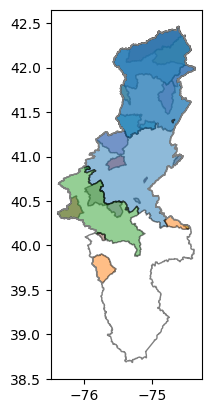

In [7]:
# Visualize
ax =node_geo_data.plot(column = 'node', edgecolor = 'black', alpha = 0.5)
drb_boundary.plot(ax=ax, color = 'none', edgecolor = '0.5')

In [8]:
# Export
node_geo_data.to_file("./DRB_shapefiles/node_basin_geometries.shp")